In [2]:
#import contingencies
import os
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from tensorflow import data as tf_data
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
import zipfile
import requests

In [ ]:
#import combined fire zip from github (collab)

# Set the URL of the ZIP file
zip_url = "https://github.com/rvt9bx/DS4002-Project3/raw/main/DATA/fire_data_combined.zip"

# Set the local path to save the downloaded ZIP file
zip_path = "/content/fire_data_combined.zip"

# Download the file from GitHub
response = requests.get(zip_url)
with open(zip_path, "wb") as file:
    file.write(response.content)

# Extract the ZIP file
extract_path = "/content/fire_data_combined"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
#import combined fire zip DATA folder (rivanna)

# set path to zip file
zip_path = "/sfs/gpfs/tardis/home/rvt9bx/ds4002/project3/DATA/fire_data_combined.zip"

# Extract the ZIP file
os.chdir('/sfs/gpfs/tardis/home/rvt9bx/ds4002/project3')
extract_path = "fire_data_combined"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [4]:
# set environment variable to avoid errors in rivanna (https://stackoverflow.com/questions/48658204/tensorflow-failed-call-to-cuinit-cuda-error-no-device)
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [5]:
image_size = (250, 250)
batch_size = 128
seed = 1337

# Load training + validation (80%) from original dataset
train_ds = keras.utils.image_dataset_from_directory(
    "fire_data_combined",
    validation_split=0.2,
    subset="training",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

# Load validation set (20%) — will split this into val and test
val_test_ds = keras.utils.image_dataset_from_directory(
    "fire_data_combined",
    validation_split=0.2,
    subset="validation",
    seed=seed,
    image_size=image_size,
    batch_size=batch_size,
)

# Split val_test_ds into 50/50 for val and test → now you have ~10% val and ~10% test
val_batches = int(0.5 * tf.data.experimental.cardinality(val_test_ds).numpy())
val_ds = val_test_ds.take(val_batches)
test_ds = val_test_ds.skip(val_batches)

Found 1900 files belonging to 2 classes.
Using 1520 files for training.
Found 1900 files belonging to 2 classes.
Using 380 files for validation.


2025-04-16 19:15:04.423152: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [6]:
# Check training class distribution
from collections import Counter

y_train = []
for _, labels in train_ds:
    y_train.extend(labels.numpy())

print("Training set class distribution:", Counter(y_train))
print("Class names:", train_ds.class_names)

Training set class distribution: Counter({1: 762, 0: 758})
Class names: ['fire', 'nofire']


2025-04-16 19:15:04.883778: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# data augmentation 
data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    # layers.RandomContrast(0.1)
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

2025-04-16 19:15:10.865674: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


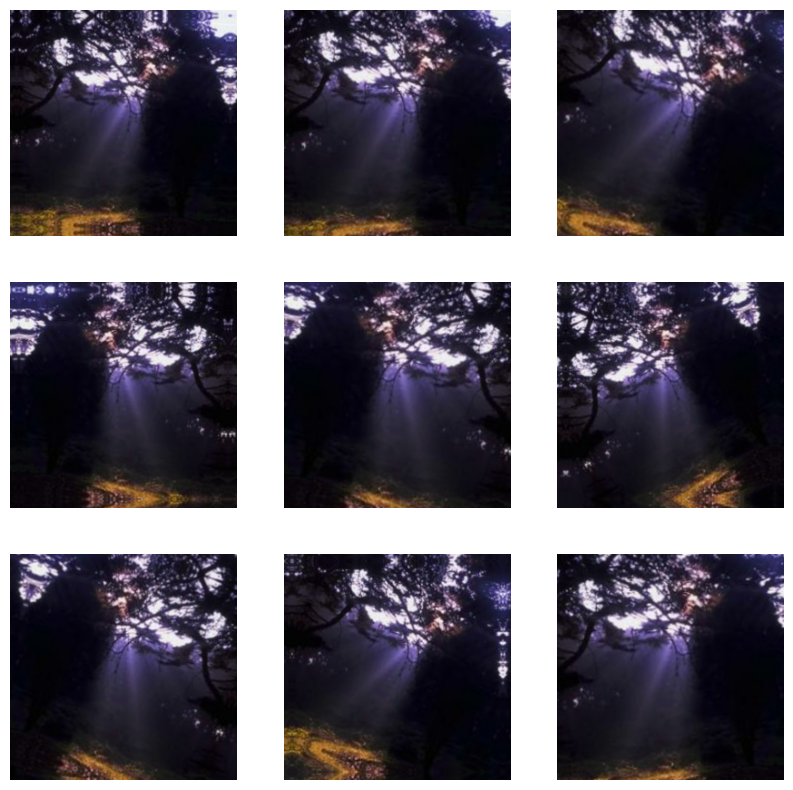

In [8]:
# show augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(np.array(augmented_images[0]).astype("uint8"))
        plt.axis("off")

In [10]:
#make the model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    
    # Data augmentation
    x = data_augmentation(inputs)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same", kernel_regularizer=regularizers.l2(0.001))(x)
    x = layers.Activation("relu")(x)

    for size in [64, 128]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2D(size, 3, padding="same", kernel_regularizer=regularizers.l2(0.001))(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
        x = layers.Dropout(0.3)(x)

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.4)(x)
    outputs = layers.Dense(units, activation="sigmoid")(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=image_size + (3,), num_classes=2)

In [11]:
#train the model
epochs = 15

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=5, restore_best_weights=True
)

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    early_stopping
]

model.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.BinaryCrossentropy(from_logits=False),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - acc: 0.5192 - loss: 0.8201 - val_acc: 0.7188 - val_loss: 0.7980
Epoch 2/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.6409 - loss: 0.7860 - val_acc: 0.7422 - val_loss: 0.7409
Epoch 3/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - acc: 0.7363 - loss: 0.7023 - val_acc: 0.8594 - val_loss: 0.5725
Epoch 4/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.8372 - loss: 0.5319 - val_acc: 0.8359 - val_loss: 0.4248
Epoch 5/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.8534 - loss: 0.4161 - val_acc: 0.9062 - val_loss: 0.3597
Epoch 6/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.8841 - loss: 0.3627 - val_acc: 0.8984 - val_loss: 0.3400
Epoch 7/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - acc: 0.9013 - loss: 0.3390 - val_acc: 0.8984 - val_loss: 0.3086
Epoch 8/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.9024 - loss: 0.3444 - val_acc: 0.9453 - val_loss: 0.2140
Epoch 9/15
12/12 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.9270 - loss: 

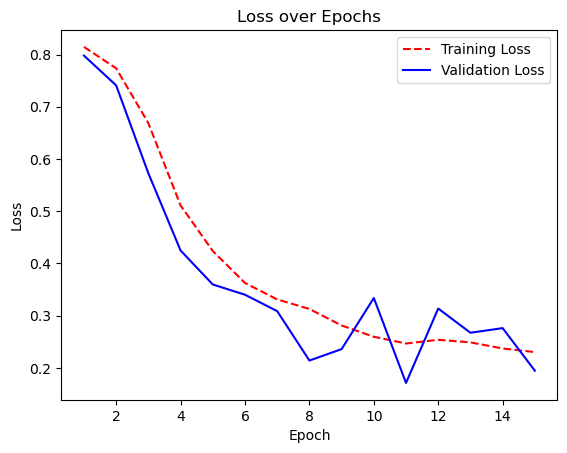

In [21]:
# Get training and test loss histories
training_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, val_loss, 'b-')
plt.title("Loss over Epochs")
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.savefig('loss_over_epochs.png')
plt.show()

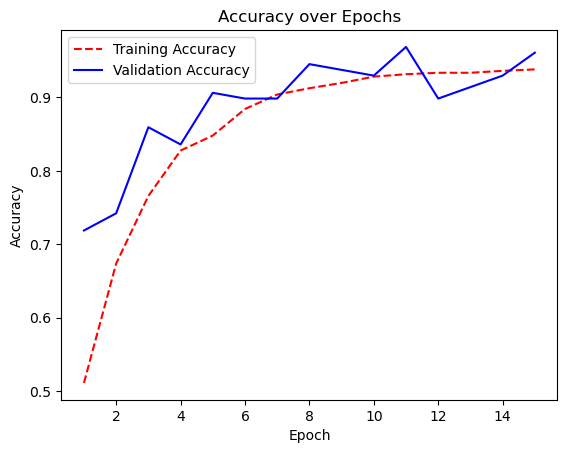

In [22]:
# Get training and test accuracy histories
training_acc = history.history['acc']
val_acc = history.history['val_acc']

# Create count of the number of epochs
epoch_count = range(1, len(training_acc) + 1)

# Visualize accuracy history
plt.plot(epoch_count, training_acc, 'r--')
plt.plot(epoch_count, val_acc, 'b-')
plt.title("Accuracy over Epochs")
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.savefig('accuracy_over_epochs.png')
plt.show()

In [16]:
# evaluate the model on test data 
results = model.evaluate(test_ds)
print("test loss, test acc:", results)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 363ms/step - acc: 0.9526 - loss: 0.2502
test loss, test acc: [0.24318373203277588, 0.9523809552192688]


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step


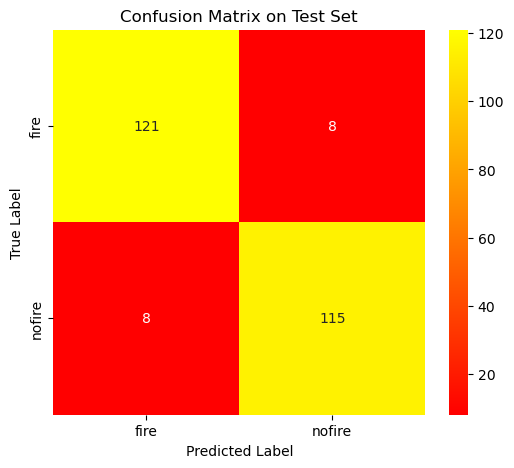

In [17]:
# evaluate where the model is going wrong/getting confused with a confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Collect predictions
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = preds > 0.5
    y_pred.extend(preds)
    y_true.extend(labels.numpy())
    class_names = labels

cm = confusion_matrix(y_true, y_pred)
class_names = val_test_ds.class_names

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='autumn',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix on Test Set')
plt.savefig("confusion_matrix.png")
plt.show()

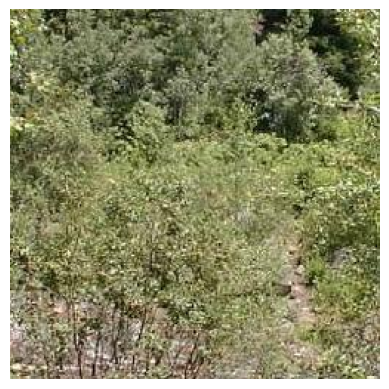

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
This image is classified as nofire.


In [35]:
# Full path to the image
image_path = "/sfs/gpfs/tardis/home/rvt9bx/ds4002/project3/fire_data_combined/nofire/abc213.jpg"

# Confirm the file exists (optional check)
if not os.path.exists(image_path):
    print("Image not found at:", image_path)
else:
    # Load and show the image
    img = keras.utils.load_img(image_path, target_size=image_size)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Preprocess image
    img_array = keras.utils.img_to_array(img)
    img_array = keras.ops.expand_dims(img_array, 0)  # Add batch dimension

    # Run prediction
    predictions = model.predict(img_array)
    if predictions[0][0]>0.5:
        print(f"This image is classified as nofire.")
    else:
        print(f"This image is classified as fire.")

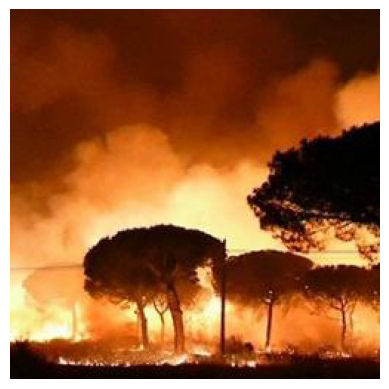

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
This image is classified as fire.


In [40]:
# Full path to the image
image_path = "/sfs/gpfs/tardis/home/rvt9bx/ds4002/project3/fire_data_combined/fire/abc005.jpg"

# Confirm the file exists (optional check)
if not os.path.exists(image_path):
    print("Image not found at:", image_path)
else:
    # Load and show the image
    img = keras.utils.load_img(image_path, target_size=image_size)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    # Preprocess image
    img_array = keras.utils.img_to_array(img)
    img_array = keras.ops.expand_dims(img_array, 0)  # Add batch dimension

    # Run prediction
    predictions = model.predict(img_array)
    if predictions[0][0]>0.5:
        print(f"This image is classified as nofire.")
    else:
        print(f"This image is classified as fire.")